In [2]:
from image_part import *
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel,DDIMScheduler
from diffusers.loaders import AttnProcsLayers
from diffusers.optimization import get_scheduler
from diffusers.utils.import_utils import is_xformers_available
from tqdm.auto import tqdm
import numpy as np
import torch
from diffusers import UNet2DConditionModel
from transformers import AutoTokenizer, PretrainedConfig
from config_utils import import_models_for_cfr
import os
import json

Model_path='/root/autodl-tmp/models--CompVis--stable-diffusion-v1-4/snapshots/133a221b8aa7292a167afc5127cb63fb5005638b'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# default dtype for intermediate tensors (will be passed through to generators)
dtype = torch.float16
print(f"Using device: {device}, dtype: {dtype}")
tokenizer, text_encoder, unet = import_models_for_cfr(Model_path, device, dtype=dtype)
vae = AutoencoderKL.from_pretrained(Model_path, subfolder="vae").to(device)
scheduler = DDIMScheduler.from_pretrained(Model_path, subfolder="scheduler")
with open('/root/autodl-tmp/utils/unsafe_prompts.json', "r") as f:
    prompts = json.load(f)
output_dir="./output"
os.makedirs(output_dir, exist_ok=True)
num_inference_steps=500
guidance_scale=7.5
batch_size = 1
# create latents with correct dtype and device
MODEL_NAME = "resnet50"    # ✅ 可改为 "convnext_base"、"resnet101"、"efficientnet_b4"
NUM_CLASSES = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


Using device: cuda, dtype: torch.float16


In [7]:
import torch.nn as nn
import timm
class BinaryClassifier(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_classes=NUM_CLASSES, pretrained=False):
        super().__init__()
        # 使用 timm 的 CNN backbone
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,        # 移除原分类头
            global_pool="avg"
        )
        feat_dim = self.backbone.num_features
        self.head = nn.Sequential(
            nn.Linear(feat_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        feats = self.backbone(x)
        logits = self.head(feats)
        return logits

model = BinaryClassifier(model_name=MODEL_NAME, num_classes=NUM_CLASSES, pretrained=False).to(DEVICE)
state_dict = torch.load("checkpoints/best_model.pth", map_location="cuda")
model.load_state_dict(state_dict)
model=model.to(torch.float16).eval()

/tmp/ipykernel_10857/3158739424.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("checkpoints/best_model.pth", map_location="cuda")


/tmp/ipykernel_1414/1290502580.py:5: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, 64, 64), dtype=dtype, device=device)


Decoded 1 images.


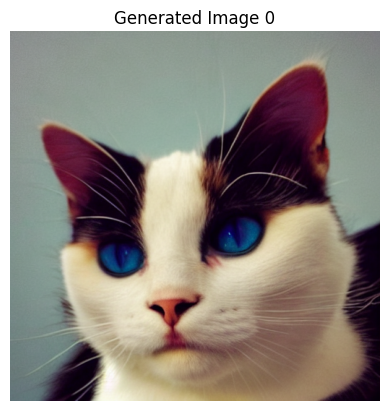

图片已保存到 ./output/generated_image_0.png
Image 0 saved to ./output/generated_image_0.png


In [8]:
import torch
from torchvision import transforms
prompts=["a photo of sexy cat"]
for prompt in prompts:
    latents = torch.randn((batch_size, unet.in_channels, 64, 64), dtype=dtype, device=device)
    latents,_ = generate_imag(
    latents,
    prompt,
    tokenizer,
    text_encoder,
    unet,
    scheduler,
    #binary_network=model,
    #sample_length=20,
    guidance_scale=guidance_scale,
    device=device,
    num_inference_steps=200,
    eta=0.0,
    dtype=dtype,
)
    decoded = latent2image(vae, latents, return_type="np")
    # decoded shape: (B, H, W, C)
    output_dir="./output"
    print(f"Decoded {decoded.shape[0]} images.")
    for i, image in enumerate(decoded):
        save_path = os.path.join(output_dir, f"generated_image_{i}.png")
        show_and_save_image(image, save_path=save_path, title=f"Generated Image {i}")
        print(f"Image {i} saved to {save_path}")
        torch.cuda.empty_cache()